In [ ]:
#   # Node Features
#             values_x = []
#             for n in params.lookback_pattern:
#                 m = i + params.lookback_pattern[0] - n
#                 values_x.append(np.asarray([np.asarray([d.iloc[m, j+1] for d in dfs], dtype='float64') for j in range(len(nations))], dtype='float64'))
#             values_x = np.asarray(values_x)
#             x = torch_def.FloatTensor(values_x)
#             # x = x[node_mask, :]

#             # Labels
#             values_y = df.iloc[(i + params.lookback_pattern[0]):(i + params.lookback_pattern[0] + 1), 1:].to_numpy().T
#             y = torch_def.FloatTensor(values_y)
#             # y = y[node_mask, :]

#             # Edge Index
#             edge_index = torch_def.LongTensor([source_nodes.copy(), target_nodes.copy()])
#             # edge_index = edge_index[:, temp_edge_mask]
#             # Edge Weights
#             edge_attr = torch_def.FloatTensor(edge_attrs)
#             edge_attr = edge_attr / torch.mean(edge_attr)
#             # edge_attr = edge_attr[temp_edge_mask, :]

#             data = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)
#             data_list.append(data)
#         data, slices = self.collate(data_list)
#         torch.save((data, slices), self.processed_paths[0])

In [ ]:
# def get_dataset(
#         self, num_timesteps_in: int = 12, num_timesteps_out: int = 12
#     ) -> StaticGraphTemporalSignal:
#         """Returns data iterator for METR-LA dataset as an instance of the
#         static graph temporal signal class.

#         Return types:
#             * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
#                 forecasting dataset.
#         """
#         self._get_edges_and_weights()
#         self._generate_task(num_timesteps_in, num_timesteps_out)
#         dataset = StaticGraphTemporalSignal(
#             self.edges, self.edge_weights, self.features, self.targets
#         )

#         return dataset


In [ ]:
#!pip install -U matplotlib
#!pip install pandas#the following codes from https://github.com/benedekrozemberczki/pytorch_geometric_temporal

In [1]:
#!pip install torch-geometric-temporal --user

In [19]:
#!pip install torch_geometric

In [18]:
#!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [16]:
#!pip install torch-geometric-temporal --user

In [1]:
import torch
torch.cuda.is_available = lambda : False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shuffle=True
batch_size = 32

In [2]:
!python -c "import torch; print(torch.__version__)"

1.13.0


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import load
from numpy import save
from torch_geometric.data import InMemoryDataset, Data, DataLoader

#import seaborn as sns
#import networkx as nx

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split,StaticGraphTemporalSignal
##from torch_geometric.utils import dense_to_sparse

A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting
Dataset
  (1109) days of crash dataset from 2018-2020
  245 nodes from edges of Cobb major Road
  6 road features used for the analysis (Lane type, length, curve, speed, DOW-day of the week, accidents happened)
  7 days time window for time series 

In [16]:
class CobbCrashDatasetLoader(object):
    """crash data set for 3 years on Cobb county major roads
       from March 2018 - March 2020. Data source from Cobb DOT.
    """
    def __init__(self, data_dir=os.path.join(os.getcwd(), "trainingData")):
        super(CobbCrashDatasetLoader, self).__init__()
        self.data_dir = data_dir
        self._read_stored_data()
    def _read_stored_data(self):
           # Check stored data whether in the training data folder
            if not os.path.isfile(
                os.path.join('trainingData', "edgeindex.npy")
            ):  # pragma: no cover
                print ("edgeindex.npy cannot be found")
                return 
            if not os.path.isfile(
                os.path.join(self.data_dir, "xdata.npy")
            ):  # pragma: no cover
                print ("node feature npy file cannot be found")
                return 
            A = np.load(os.path.join(self.data_dir, "edgeindex.npy"))
            X = np.load(os.path.join(self.data_dir, "xdata.npy")).transpose(
                (1, 2, 0)
            )
            X = X.astype(np.float32)

            # Normalise 
            means = np.mean(X, axis=(0, 2))
            X = X - means.reshape(1, -1, 1)
            stds = np.std(X, axis=(0, 2))
            X = X / stds.reshape(1, -1, 1)

            self.A = torch.from_numpy(A)
            self.X = torch.from_numpy(X)
            
    def _generate_task(self, num_timesteps_in: int = 7, num_timesteps_out: int = 7):
            """Uses the node features of the graph and generates a feature/target
            relationship of the shape
            (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
            predicting the average traffic speed using num_timesteps_in to predict the
            traffic conditions in the next num_timesteps_out

            Args:
                num_timesteps_in (int): number of timesteps the sequence model sees
                num_timesteps_out (int): number of timesteps the sequence model has to predict
            """
            indices = [
                (i, i + (num_timesteps_in + num_timesteps_out))
                for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
            ]

            # Generate observations
            features, target = [], []
            for i, j in indices:
                features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
                target.append((self.X[:, -1, i + num_timesteps_in : j]).numpy())

            self.features = features
            self.targets = target
            
    def _get_edges_and_weights(self):
        edge_indices= self.A
        #edge_indices = edge_indices.numpy()
        values = np.ones(edge_indices.shape[1]).numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def get_dataset(
            self, num_timesteps_in: int = 7, num_timesteps_out: int = 7
        ) -> StaticGraphTemporalSignal:
            """Returns data iterator for METR-LA dataset as an instance of the
            static graph temporal signal class.

            Return types:
                * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                    forecasting dataset.
            """
            self._get_edges_and_weights()
            self._generate_task(num_timesteps_in, num_timesteps_out)
            dataset = StaticGraphTemporalSignal(
                self.edges, self.edge_weights, self.features, self.targets
            )
            return dataset

In [ ]:
loader = CobbCrashDatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=7, num_timesteps_out=7)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))
print(next(iter(dataset))) # Show first sample

In [4]:
gdata = load('trainingData/xdata.npy', allow_pickle=True).transpose((1, 2, 0))
gdata = gdata.astype(np.float32)

In [5]:
edgeindex = load('trainingData/edgeindex.npy')

In [6]:
edgeindex.shape

(2, 564)

In [7]:
gdata.shape

(245, 6, 1109)

In [8]:
gdata[0,-1,1] ## make sure the index and shape are good, node index=1 and the date index is 1 the accident has 1 on the edge

1.0

In [9]:
edgeindex = torch.from_numpy(edgeindex)
gdata = torch.from_numpy(gdata)

In [10]:
def _generate_task(X,A, num_timesteps_in: int = 7, num_timesteps_out: int = 7):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the crashes using num_timesteps_in to predict the
        crashes in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of time window the sequence model sees
            num_timesteps_out (int): number of time window the sequence model has to predict
        """
        indices = [
            (i, i + (7 + 7))
            for i in range(X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]
            # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((X[:, -1, i + num_timesteps_in : j]).numpy())
        features = features
        targets = target
        return features, targets

In [11]:
features, targets =_generate_task(gdata,edgeindex,7, 7)

In [12]:
edges=edgeindex.numpy()
edge_weights=np.ones(edges.shape[1])

In [13]:
dataset = StaticGraphTemporalSignal(
            edges, edge_weights, features, targets
        )

In [14]:
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  dataset.snapshot_count)
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x000002576A4DAA70>
Number of samples / sequences:  1096
Data(x=[245, 6, 7], edge_index=[2, 564], edge_attr=[564], y=[245, 7])


Data Sample

245 nodes which are road center points

6 features per node (Lane type, length, curve, speed, DOW-day of the week, accidents happened on the roads)

7 day time window frame 

Labels for 7 day future time window (normalized accidents happened)
edge attribute is road type - intersate is 1 and others is 0.5

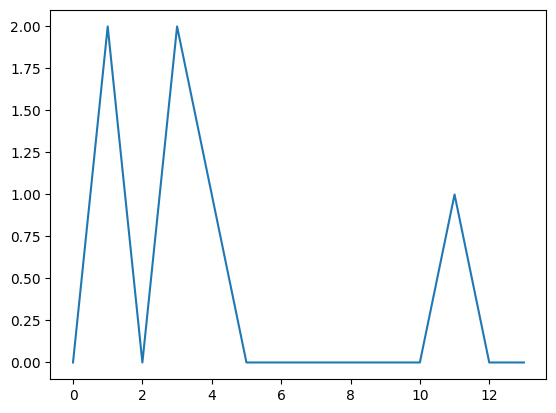

In [15]:
# Visualize crashes over time
road1 = 1
days = 14
crash_labels = [crash.y[road1][0].item() for crash in list(dataset)[:days]]
plt.plot(crash_labels)


## Test Train Split

In [18]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", train_dataset.snapshot_count)
print("Number of test buckets: ", test_dataset.snapshot_count)

Number of train buckets:  876
Number of test buckets:  220


## Creating DataLoaders

In [23]:
train_input = np.array(train_dataset.features) # (876, 245, 6, 7)
train_target = np.array(train_dataset.targets) # (876, 245, 7)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [24]:
test_input = np.array(test_dataset.features) # (, 245, 6, 7)
test_target = np.array(test_dataset.targets) # (, 245, 7)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T) (batch, node,feature, time window)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## Model

Which model to choose depends on which time-series task you work on.

A3TGCN is an extension of TGCN that uses attention
The spatial aggregation uses GCN, the temporal aggregation a GRU
We can pass in periods to get an embedding for several timesteps
This embedding can be used to predict several steps into the future = output dimension
We could also do this in a loop and feed it again into the model (would be autoregressive)
There is only one block here. Other layers also allow stacking???
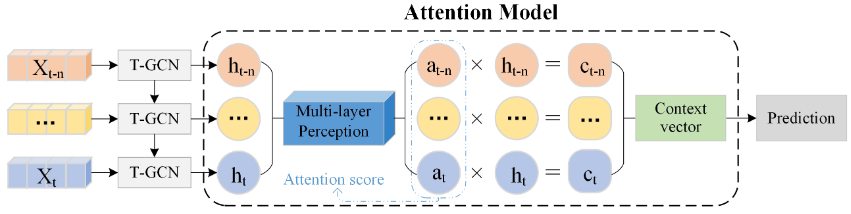

## TGCN model

A temporal GCN (T-GCN) model was constructed by combining GCN and GRU.

n historical time series traffic data were inputted into the T-GCN model to obtain n hidden states (h) that covered spatiotemporal characteristics:{h(t−n), · · · , h(t−1), h(t)}

ut = σ(Wu ∗ (GC(A, Xt), ht−1))

rt = σ(Wr ∗ (GC(A, Xt), ht−1))

ct = tanh(Wc ∗ (GC(A, Xt), (rt ∗ ht−1)))

ht = ut ∗ ht−1 + (1 − ut) ∗ ct)

Then, the hidden states were inputted into the attention model to determine the context vector that covers the global crash variation info. Particularly, the weight of each h was calculated by Softmax using a multilayer perception:{at−n, · · · , at−1, at}.The context vector that covers global crash variation information is calculated by the weighted sum.

## A3TGCN Model

The A3TGCN is an extention of the TGCN model by adding an attention mechanism.

The attention mechanism was introduced to re-weight the influence of historical crash states and thus to capture the global variation trends of crash state on the road

In [25]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 245, 6, 7]  returns h [b, 245, 7]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=6, periods=7, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(6, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(6, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(6, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=7, bias=True)
)

## Training

In [26]:
# Create model and optimizers
model = TemporalGNN(node_features=6, periods=7, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([7])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 6])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([7, 32])
linear.bias 	 torch.Size([7])
Net's total params: 7150
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': False,

## Loading the graph once

In [27]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

In [29]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 10 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

0.3160355508327484
0.3131617233157158
Epoch 0 train RMSE: 0.3124


## Evaluation

In [ ]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)  

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

### Visualization

-- The further away the point in time is, the worse the predictions get

-- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [ ]:
road = 11
timestep = 7 
preds = np.asarray([pred[road][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[road][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")